In [2]:
! pwd

/home/yoshraf/projects/master-analysis-inequality-mobility/inequality-mobility/notebooks/final/mode-choice


In [3]:
parameters = catalog.load("parameters")

2025-09-13 23:00:58,232 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import vaex
from matplotlib import pyplot as plt


from shapely.geometry import Point
from shapely.ops import unary_union

import statsmodels.api as sm
import matplotlib.colors as colors

from datetime import datetime
from typing import Any, Dict, Tuple

pd.set_option('display.max_columns', None)

### Functions & General Definitions

In [5]:
EPSG = 31983

colors_dict = {'Peripheral Group': '#E8D202', 'Central Group': '#2F6B8E'}
cmap = colors.ListedColormap(list(colors_dict.values()))

def create_gis_point(df_raw: pd.DataFrame, dict_gis: Dict) -> gpd.GeoDataFrame:
    df_raw.dropna(subset=dict_gis["loc_domicilio"], inplace=True)
    for k, v in dict_gis.items():
        df_raw[k] = gpd.points_from_xy(df_raw[v[0]], df_raw[v[1]])
    if df_raw.dtypes[df_raw.dtypes == 'geometry'].shape[0] > 1:
        gdf = gpd.GeoDataFrame(df_raw,  geometry='loc_domicilio', crs = "EPSG:22523")
    else:
        gdf = gpd.GeoDataFrame(df_raw, crs = "EPSG:22523")
    return gdf

def feature_bens_per_capita(gdf: gpd.GeoDataFrame, cols: list, ref: str) -> gpd.GeoDataFrame:
    for c in cols:
        gdf[f"per_{c}"] = gdf[c] / gdf[ref]
    return gdf

### Prep Metro

In [6]:
subways_07e17 = parameters['features']['did']['subway']['entre_07e17']
subways_17e23 = parameters['features']['did']['subway']['entre_17e23']
subways_07e17_all = subways_07e17['central'] + subways_07e17['periferia']
subways_17e23_all = subways_17e23['central'] + subways_17e23['periferia']

gdf_metro_open = catalog.load("metro_final")

gdf_acc = catalog.load("acc_joined")
df_quadras_results = gpd.read_file("data/quadras_classificadas.shp")
df_quadras_results['ds_groups'] = df_quadras_results['groups'].map({'1': 'Peripheral Group', '2': 'Central Group'})

2025-09-13 23:00:59,413 - kedro.io.data_catalog - INFO - Loading data from `metro_final` (GeoJSONDataSet)...
2025-09-13 23:00:59,537 - kedro.io.data_catalog - INFO - Loading data from `acc_joined` (GeoJSONDataSet)...


In [7]:
gdf_metro_open.Inauguração = gdf_metro_open.Inauguração.astype(str)

In [8]:
gdf_metro_open['entre_07e17'] = gdf_metro_open.emt_nome.isin(subways_07e17_all)
gdf_metro_open['entre_17e23'] = gdf_metro_open.emt_nome.isin(subways_17e23_all)

gdf_metro_open['entre_07e17_central'] = gdf_metro_open.emt_nome.isin(subways_07e17['central'])
gdf_metro_open['entre_17e23_central'] = gdf_metro_open.emt_nome.isin(subways_17e23['central'])

gdf_metro_open['entre_07e17_periferia'] = gdf_metro_open.emt_nome.isin(subways_07e17['periferia'])
gdf_metro_open['entre_17e23_periferia'] = gdf_metro_open.emt_nome.isin(subways_17e23['periferia'])

### Prep ODs

In [9]:
od2023_filtered = catalog.load('od2023_filtered')

2025-09-13 23:01:06,086 - kedro.io.data_catalog - INFO - Loading data from `od2023_filtered` (ParquetDataSet)...


In [10]:
od2023_filtered.identifica_pessoa.nunique()

52619

In [11]:
od2023_filtered = catalog.load('od2023_filtered')
od2017_filtered = catalog.load('od2017_filtered')
od2007_filtered = catalog.load('od2007_filtered')

features_23 = parameters['features']['od2023']['features']
features_17 = parameters['features']['od2017']['features']
features_07 = parameters['features']['od2007']['features']
map_od_17_to_23 = dict(zip(features_17, features_23))

GEO_DOM = ["coordenada_x_do_domicilio", "coordenada_y_do_domicilio"]
GEO_ORI = ["coordenada_x_origem", "coordenada_y_origem"]
GEO_DES = ["coordenada_x_destino", "coordenada_y_destino"]
DICT_GIS = {"loc_domicilio": GEO_DOM, "loc_origem": GEO_ORI, "loc_destino": GEO_DES}
k = "loc_domicilio"

bens = ['quantidade_de_automoveis', "renda_familiar_mensal"]
per = "total_de_moradores_do_domicilio"

2025-09-13 23:01:06,374 - kedro.io.data_catalog - INFO - Loading data from `od2023_filtered` (ParquetDataSet)...
2025-09-13 23:01:06,459 - kedro.io.data_catalog - INFO - Loading data from `od2017_filtered` (ParquetDataSet)...
2025-09-13 23:01:06,569 - kedro.io.data_catalog - INFO - Loading data from `od2007_filtered` (ParquetDataSet)...


In [12]:
od2017_filtered.columns = features_23
od2007_filtered['od'] = 2007
od2017_filtered['od'] = 2017
od2023_filtered['od'] = 2023
# prep_date
od2007_filtered.data_da_entrevista = pd.to_datetime(od2007_filtered.data_da_entrevista, errors='ignore')
od2017_filtered.data_da_entrevista = pd.to_datetime(od2017_filtered.data_da_entrevista, format='%d%m%Y')
od2023_filtered.data_da_entrevista = pd.to_datetime(od2023_filtered.data_da_entrevista)

df_od = pd.concat([od2023_filtered, od2017_filtered, od2007_filtered])
df_od = df_od[df_od['total_de_viagens_da_pessoa'] > 0]

In [13]:
print("Create main location gis points")
df_od_prep = create_gis_point(df_od, DICT_GIS)
df_od_prep["dist_od"] = df_od_prep.apply(
    lambda x: x["loc_origem"].distance(x["loc_destino"]), axis=1)
df_od_prep = feature_bens_per_capita(df_od_prep, bens, per)

# Treatment
geo_metro_treatment = unary_union(gdf_metro_open[gdf_metro_open.entre_17e23]["geometry"])
geo_metro_treatment_centro = unary_union(gdf_metro_open[gdf_metro_open.entre_17e23_central]["geometry"])
geo_metro_treatment_perifa = unary_union(gdf_metro_open[gdf_metro_open.entre_17e23_periferia]["geometry"])

geo_metro_all = unary_union(gdf_metro_open["geometry"])
print("Distance to Subway")
df_od_prep[f"{k}_dist_metro_treatment"] = df_od_prep[k].apply(lambda x: geo_metro_treatment.distance(x))
df_od_prep[f"{k}_dist_metro_treatment_centro"] = df_od_prep[k].apply(lambda x: geo_metro_treatment_centro.distance(x))
df_od_prep[f"{k}_dist_metro_treatment_periferia"] = df_od_prep[k].apply(lambda x: geo_metro_treatment_perifa.distance(x))
# Controle
# Distantes de todos os metro
# Mas que não tão distantes dos metros tratementos
df_od_prep[f"{k}_dist_metro"] = df_od_prep[k].apply(lambda x: geo_metro_all.distance(x))

df_od_prep = df_od_prep[df_od_prep[f"{k}_dist_metro_treatment"] <= 2_000]
df_od_prep['centro'] = (df_od_prep[f"{k}_dist_metro_treatment_centro"] <= 2_000)

Create main location gis points
Distance to Subway


In [14]:
k = "loc_domicilio"

df_od_tratamento = df_od_prep[df_od_prep[f"{k}_dist_metro_treatment"] <= 600]
df_od_control = df_od_prep[(df_od_prep[f"{k}_dist_metro"] >= 1500)]

gdf_plot_tratamento = gpd.GeoDataFrame(df_od_tratamento[['loc_domicilio', f"{k}_dist_metro", f"{k}_dist_metro_treatment", "centro"]], geometry=k, crs = "EPSG:22523")
gdf_plot_controle = gpd.GeoDataFrame(df_od_control[['loc_domicilio', f"{k}_dist_metro", f"{k}_dist_metro_treatment", "centro"]], geometry=k, crs = "EPSG:22523")

In [15]:
esmeralda_amarelo_c4 = {
    "amarelo": '#E8D202',
    "verde_principal": "#25AC82",   # o tom original
    "verde_claro": "#5FC9A6",       # tom mais suave para preenchimentos
    "verde_clarissimo": "#B4E6D3",  # bem suave, bom para fundo
}

esmeralda_amarelo_c2 = {
    "verde_principal": "#25AC82",   # o tom original
    "amarelo": '#E8D202',
}

cmap_esmeralda_amarelo_c2 = colors.ListedColormap(list(esmeralda_amarelo_c2.values()))
cmap_esmeralda_amarelo_c4 = colors.ListedColormap(list(esmeralda_amarelo_c4.values()))

In [16]:
gpd_distritos = gpd.read_file("data/SIRGAS_SHP_distrito.shp")

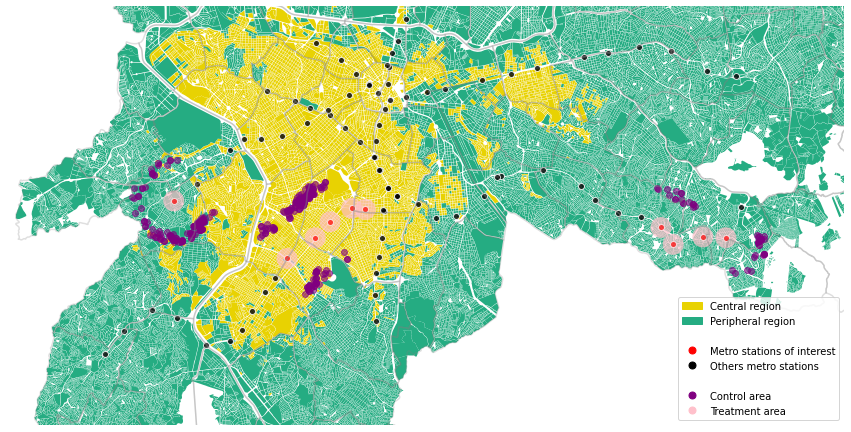

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import geopandas as gpd

# Your figure and initial plot
t = 1.5
fig, ax = plt.subplots(figsize=(10*t, 12*t))

# First GeoDataFrame with automatic legend
f = df_quadras_results.sample(frac=1).plot(column="groups", legend=False, cmap=cmap_esmeralda_amarelo_c2, ax=ax)

# Second layer without legend
gpd_distritos.boundary.plot(color='grey', ax=f, alpha=.25)
b400_metro = gdf_metro_open[gdf_metro_open.entre_17e23].buffer(500)
f = b400_metro.plot(ax=f, color='pink', alpha=.7)
gdf_metro_open[~gdf_metro_open['entre_17e23']].plot(ax=ax, color='black', alpha=.8, edgecolor='white')
gdf_metro_open[gdf_metro_open['entre_17e23']].plot(ax=ax, color='red', alpha=.7, edgecolor='white')
# Tratamento
gdf_plot_controle.sample(350).plot(ax=ax, color="purple", alpha=.6)


patches = [
    mpatches.Patch(color=cmap_esmeralda_amarelo_c4.colors[0], label='Central region'),
    mpatches.Patch(color=cmap_esmeralda_amarelo_c4.colors[1], label='Peripheral region'),
    mpatches.Patch(color='white', label=' '),
    mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=7, label='Metro stations of interest'),
    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=7, label='Others metro stations'),
    mpatches.Patch(color='white', label=' '),
    mlines.Line2D([], [], color='purple', marker='o', linestyle='None', markersize=7, label='Control area'),
    mlines.Line2D([], [], color='pink', marker='o', linestyle='None', markersize=7, label='Treatment area'),
]
ax.legend(handles=patches, loc='lower right')

# Background
ax.axis('off')
f.set_xlim(left=315000 , right=355000)
f.set_ylim(top=7.399 * 10 **6 , bottom=7.3790 * 10 **6)
plt.savefig('figs/map_sp_did_map.png', dpi=300, bbox_inches='tight')
plt.show()

### Prep DID

In [19]:
IDX = [
    "od",
    "identifica_pessoa"
]

COLS = [
    "od",
    "identifica_pessoa",
    "idade_em_anos",
    "sexo",
    "per_quantidade_de_automoveis",
    "per_renda_familiar_mensal",
    "loc_domicilio_dist_metro",
    "total_de_viagens_da_pessoa",
    "mean_dist_od",
    "modo_principal_da_viagem",
    "centro"
]

LABEL = "modo_principal_da_viagem"

def total_dist_od(df):
    df_dist_od = pd.DataFrame(df.groupby(IDX)["dist_od"].mean())
    df_dist_od.columns = ["mean_dist_od"]
    return df.merge(df_dist_od, on=IDX)

def subway_rate(df):
    l_metro = ["Metrô", 'Monotrilho', 'Trem']
    l_car = ["Dirigindo Automóvel", "Passageiro de Automóvel", "Dirigindo automóvel", "Passageiro de automóvel"]
    l_bus = ["Ônibus/micro-ônibus/perua do município de São Paulo", "Ônibus/micro-ônibus/van do município de São Paulo", "Ônibus/micro-ônibus/van metropolitano", "Ônibus/micro-ônibus/perua metropolitano"]
    df = df[COLS].copy()
    # Dropnan (viagens não realizadas)
    df = df.dropna()
    # Map de metro para
    df["label_metro"] = df[LABEL].apply(lambda x: 1 if x in l_metro else 0)
    df["label_car"] = df[LABEL].apply(lambda x: 1 if x in l_car else 0)
    df["label_bus"] = df[LABEL].apply(lambda x: 1 if x in l_bus else 0)

    # Group by person
    df_mean = pd.DataFrame(df.groupby(IDX)[["label_metro", "label_car", "label_bus"]].mean())
    df_mean.columns = ["Taxa de Metrô", "Taxa de Carro", "Taxa de Ônibus"]
    df2 = df.merge(df_mean, on=IDX)
    df2 = df2.drop(columns=[LABEL]).drop_duplicates()
    return df2

In [20]:
df_od_prep_2 = total_dist_od(df_od_prep)
# df_od_prep_2[LABEL].value_counts(normalize=True)
dataset = subway_rate(df_od_prep_2)

dataset["T_200"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 200 else 0)
dataset["T_300"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 300 else 0)
dataset["T_400"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 400 else 0)
dataset["T_500"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 500 else 0)
dataset["T_600"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 600 else 0)
dataset["T_700"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 700 else 0)
dataset["T_800"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 800 else 0)
dataset["T_900"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 900 else 0)
dataset["T_1000"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 1000 else 0)
dataset["T_1100"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 1100 else 0)
dataset["T_1200"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 1200 else 0)
dataset["T_1300"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 1300 else 0)
dataset["T_1400"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 1400 else 0)
dataset["T_1500"] = dataset["loc_domicilio_dist_metro"].apply(lambda x: 1 if x < 1500 else 0)

In [21]:
dataset["dist_od_0_500"] = dataset["mean_dist_od"].apply(lambda x: 1 if x <= 500 else 0)
dataset["dist_od_500_1500"] = dataset["mean_dist_od"].apply(lambda x: 1 if (x <= 1_500) & (x > 500) else 0)
dataset["total_trips_more_2"] = dataset["total_de_viagens_da_pessoa"].apply(lambda x: 1 if x > 2 else 0)
dataset['OD23'] = (dataset.od == 2023).astype(int)

dataset_aux = dataset.set_index(IDX)
dataset_aux = pd.get_dummies(dataset_aux, drop_first=True).reset_index()

In [22]:
# OD 17 e 23
dataset_did = dataset_aux[(dataset_aux.od != 2007)].set_index(IDX)
dataset_perif_aux = dataset_did[~dataset_did.centro]
dataset_center_aux = dataset_did[dataset_did.centro]
# OD 07
dataset_did_07 = dataset_aux[(dataset_aux.od == 2007)].set_index(IDX)
dataset_perif_aux_07 = dataset_did_07[~dataset_did_07.centro]
dataset_center_aux_07 = dataset_did_07[dataset_did_07.centro]

### DID Descritiva

In [23]:
outcome = ["Taxa de Metrô", "Taxa de Carro", "Taxa de Ônibus"]

COLS_MODELING = [
    "idade_em_anos",
    "per_quantidade_de_automoveis",
    "per_renda_familiar_mensal",
    "OD23",
    "sexo_Masculino",
    "mean_dist_od"
]


col_T = 'T_500'
col_C = 'T_1500'

# Função para gerar estatísticas descritivas
def gerar_estatisticas(dataset, nome_regiao):
    condicoes = [
        ((dataset["OD23"] == 0) & (dataset[col_C] == 0), "Antes e Controle"),
        ((dataset["OD23"] == 0) & (dataset[col_T] == 1), "Antes e Tratamento"),
        ((dataset["OD23"] == 1) & (dataset[col_C] == 0), "Depois e Controle"),
        ((dataset["OD23"] == 1) & (dataset[col_T] == 1), "Depois e Tratamento"),
    ]
    
    descritores = []
    for condicao, tipo in condicoes:
        stats = dataset[condicao][COLS_MODELING + outcome].describe().T[
            [
                "count",
                "mean",
                "std"
            ]
        ]
        stats = stats.assign(Tipo=tipo)
        descritores.append(stats)
    
    return pd.concat(descritores, axis=1)

# Geração dos dataframes para cada região
df_stat_perif = gerar_estatisticas(dataset_perif_aux, "Periferia")
df_stat_center = gerar_estatisticas(dataset_center_aux, "Centro")

/home/yoshraf/projects/master-analysis-inequality-mobility/venv/lib/python3.8/site-packages/pandas/core/nanops.py:1723: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=1, interpolation=interpolation)


In [24]:
# df_stat_center.round(2).to_excel('df_stat_center.xlsx')
df_stat_center.round(2)

,count,mean,std,Tipo,count,mean,std,Tipo,count,mean,std,Tipo,count,mean,std,Tipo
idade_em_anos,371.0,41.85,20.46,Antes e Controle,1069.0,41.53,20.18,Antes e Tratamento,292.0,42.41,20.04,Depois e Controle,722.0,41.04,19.56,Depois e Tratamento
per_quantidade_de_automoveis,371.0,0.38,0.33,Antes e Controle,1069.0,0.44,0.34,Antes e Tratamento,292.0,0.38,0.35,Depois e Controle,722.0,0.41,0.32,Depois e Tratamento
per_renda_familiar_mensal,371.0,3401.94,2484.42,Antes e Controle,1069.0,3345.78,2459.16,Antes e Tratamento,292.0,6032.44,5357.73,Depois e Controle,722.0,6888.68,5983.79,Depois e Tratamento
OD23,371.0,0.00,0.00,Antes e Controle,1069.0,0.00,0.00,Antes e Tratamento,292.0,1.00,0.00,Depois e Controle,722.0,1.00,0.00,Depois e Tratamento
sexo_Masculino,371.0,0.52,0.50,Antes e Controle,1069.0,0.48,0.50,Antes e Tratamento,292.0,0.52,0.50,Depois e Controle,722.0,0.51,0.50,Depois e Tratamento
mean_dist_od,371.0,3645.78,4241.31,Antes e Controle,1069.0,4184.09,4011.42,Antes e Tratamento,292.0,3833.65,4391.66,Depois e Controle,722.0,4384.02,3994.29,Depois e Tratamento
Taxa de Metrô,371.0,0.04,0.17,Antes e Controle,1069.0,0.16,0.33,Antes e Tratamento,292.0,0.06,0.22,Depois e Controle,722.0,0.20,0.37,Depois e Tratamento
Taxa de Carro,371.0,0.33,0.41,Antes e Controle,1069.0,0.37,0.44,Antes e Tratamento,292.0,0.36,0.45,Depois e Controle,722.0,0.39,0.47,Depois e Tratamento
Taxa de Ônibus,371.0,0.17,0.31,Antes e Controle,1069.0,0.12,0.29,Antes e Tratamento,292.0,0.16,0.34,Depois e Controle,722.0,0.07,0.24,Depois e Tratamento


In [23]:
# df_stat_perif.round(2).to_excel('df_stat_perif.xlsx')

### DID Model

In [25]:

def diff_diff(df, T, features, label = "Taxa de Metrô", report=False, return_model=False):
    col_control = ['T_1500']
    features = features + [T] + col_control
    
    df_model = df[features].copy()
    df_model[df_model[col_control] == 0]
    df_model = df_model.drop(columns=col_control)
    df_model["OD23:T"] = df_model["OD23"].values * df_model[T].values
    df_model = sm.add_constant(df_model)
    res = sm.OLS(df[label].values, df_model).fit()
    if report:
        print(res.summary())
    df_ci = res.conf_int()[res.conf_int().index=='OD23:T']
    df_ci.columns = ["LB", "UB"]
    df_ci["coef"] = df_ci.mean(axis=1)
    if return_model:
        return res
    return df_ci


def random_t_did_test(df, t, features, label):
    rng = np.random.default_rng(0)
    df2 = df.copy()
    rng.shuffle(df2[t].values)
    print("\n-----------------")
    print("Original")
    print("-----------------\n")
    did = diff_diff(df, t, features, label=label, report=True, return_model=True)
    print("\n-----------------")
    print("Random Assignment Treatment Label")
    print("-----------------\n")
    did2 = diff_diff(df2, t, features, report=True, return_model=True)
    return did2

def plot_final_table(did):
    p001 = pd.core.series.Series([1 if e <= 0.01 else 0 for e in did.pvalues], index=did.params.index)
    p005 = pd.core.series.Series([1 if e <= 0.05 else 0 for e in did.pvalues], index=did.params.index)
    p010 = pd.core.series.Series([1 if e <= 0.10 else 0 for e in did.pvalues], index=did.params.index)

    df = pd.concat((did.params, did.bse, did.pvalues, p001, p005, p010), axis=1)
    df.columns = ["coef", "std errors", "pvalues", "p<1%", "p<5%", "p<10%"]
    df["r2"] = did.rsquared
    return df

In [26]:
diff_diff(dataset_perif_aux, 'T_500', COLS_MODELING, report=True)
diff_diff(dataset_center_aux, 'T_500', COLS_MODELING, report=True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     144.3
Date:                Sat, 13 Sep 2025   Prob (F-statistic):          3.39e-204
Time:                        20:26:11   Log-Likelihood:                -118.65
No. Observations:                2862   AIC:                             255.3
Df Residuals:                    2853   BIC:                             308.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

,LB,UB,coef
OD23:T,-0.015682,0.047724,0.016021


### Parallel Trends

In [27]:
esmeralda_roxo = {
    "roxo": "#481C6E",
    "verde_principal": "#25AC82"
}

cmap_esmeralda_roxo = colors.ListedColormap(list(esmeralda_roxo.values()))
cmap_esmeralda_roxo

def parallel_prep_plot(
    df_od07_p,
    df_od07_c,
    df_od_p,
    df_od_c,
    T_col
):
    df_od07_p.loc[:,'OD23'] = -1
    df_od07_c.loc[:,'OD23'] = -1
    df_plot_perif_07 = pd.DataFrame(df_od07_p.groupby(["OD23", T_col])["Taxa de Metrô"].mean()).reset_index()
    df_plot_center_07 = pd.DataFrame(df_od07_c.groupby(["OD23", T_col])["Taxa de Metrô"].mean()).reset_index()
    df_plot_perif = pd.DataFrame(df_od_p.groupby(["OD23", T_col])["Taxa de Metrô"].mean()).reset_index()
    df_plot_center = pd.DataFrame(df_od_c.groupby(["OD23", T_col])["Taxa de Metrô"].mean()).reset_index()
    # Concat 07
    df_plot_perif_full = pd.concat([df_plot_perif_07, df_plot_perif])
    df_plot_center_full = pd.concat([df_plot_center_07, df_plot_center])
    #  Prep
    df_plot_perif_full['Groups']  = df_plot_perif_full[T_col].map({1: 'Treatment', 0: 'Control'})
    df_plot_center_full['Groups']  = df_plot_center_full[T_col].map({1: 'Treatment', 0: 'Control'})
    df_plot_perif_full['Year'] = df_plot_perif_full['OD23'].map({-1: 2007, 0: 2017, 1: 2023}).values
    df_plot_center_full['Year'] = df_plot_center_full['OD23'].map({-1: 2007, 0: 2017, 1: 2023}).values
    df_plot_perif_full['Metro Share'] = df_plot_perif_full['Taxa de Metrô'] * 100
    df_plot_center_full['Metro Share'] = df_plot_center_full['Taxa de Metrô'] *100
    return df_plot_perif_full, df_plot_center_full


def plot_metro_share(df, title='Region Cluster 1 (600m)', full=True, figsize_factor=0.8, ylim=(0, 35)):
    """
    Plota a participação do metrô ao longo dos anos para grupos de controle e tratamento.

    Parâmetros:
    - df: DataFrame contendo colunas 'Groups', 'Year' e 'Metro Share'
    - title: Título do gráfico
    - figsize_factor: Fator de escala para o tamanho da figura
    - ylim: Limites do eixo y
    """
    colors = {"Control": "#25AC82", "Treatment": "#481C6E"}
    colors = {"Control": cmap_esmeralda_roxo.colors[1], "Treatment": cmap_esmeralda_roxo.colors[0]}
    title_ = ''
    if full:
        title_ = 'full'
    fig, ax = plt.subplots(figsize=(14 * figsize_factor, 8 * figsize_factor))

    for group in ['Control', 'Treatment']:
        group_data = df[df.Groups == group]
        ax.plot(group_data['Year'], group_data['Metro Share'],
                color=colors[group], label=group,
                marker="o", linestyle='--', markersize=8)

    ax.grid(color='grey', linestyle='-', axis='x', linewidth=.01)
    ax.grid(color='grey', linestyle='-', axis='y', linewidth=.3)

    ax.legend(loc='upper left', labelcolor='black', frameon=0)

    ax.set_ylim(ylim)
    ax.set_ylabel('Metro Share (%)', color='black')
    ax.set_xlabel('Year', color='black')
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='black')

    ax.set_title(title, color='black')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
    
#     plt.savefig(f"diff-in-diffs-plot-{title_} - " + title, dpi=300, bbox_inches='tight')
    plt.show()

/home/yoshraf/projects/master-analysis-inequality-mobility/venv/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


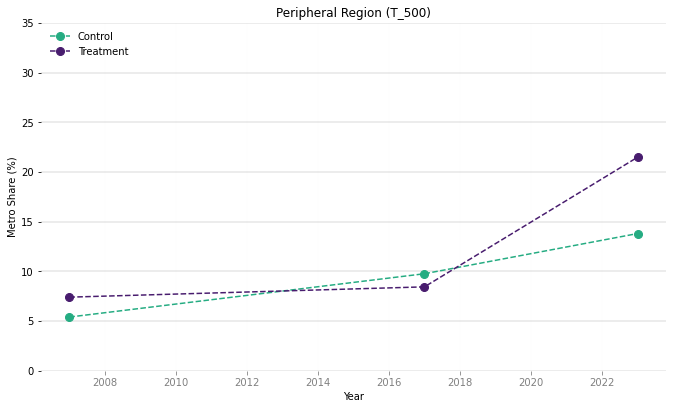

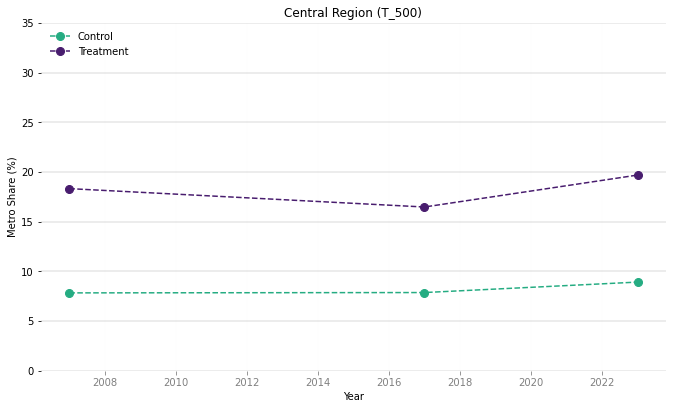

In [28]:
T_col = 'T_500'
df_plot_perif_full, df_plot_center_full = parallel_prep_plot(
    dataset_perif_aux_07,
    dataset_center_aux_07,
    dataset_perif_aux,
    dataset_center_aux,
    T_col
)

df_plot_perif_notfull = df_plot_perif_full[df_plot_perif_full.OD23 >= 0]
df_plot_center_notfull = df_plot_center_full[df_plot_center_full.OD23 >= 0]

plot_metro_share(df_plot_perif_full, f'Peripheral Region ({T_col})', True)
plot_metro_share(df_plot_center_full, f'Central Region ({T_col})', True)

### Many Distance

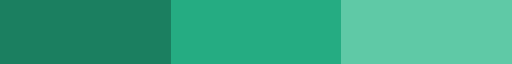

In [29]:
verde_esmeralda_2 = {
    "verde_escuro": "#1B7F60",
    "verde_principal": "#25AC82",
    "verde_claro": "#5FC9A6",
}

cmap_verde_2 = colors.ListedColormap(list(verde_esmeralda_2.values()))
cmap_verde_2

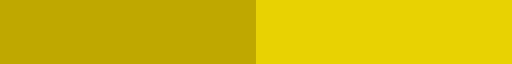

In [30]:
amarelo_2 = {
    "amarelo_escuro": "#BFA800",
    "amarelo": '#E8D202',
}

cmap_amarelo_2 = colors.ListedColormap(list(amarelo_2.values()))
cmap_amarelo_2

In [31]:
def many_distance_plot(dataset_perif_aux, dataset_center_aux, list_t, modo="Taxa de Metrô", save=False):
    df_res_perif = pd.concat([diff_diff(dataset_perif_aux, t, COLS_MODELING, label=modo).assign(T=t) for t in list_t]).assign(Centro=0)
    df_res_center = pd.concat([diff_diff(dataset_center_aux, t, COLS_MODELING, label=modo).assign(T=t) for t in list_t]).assign(Centro=1)
    print(df_res_perif)
    print(df_res_center)
    colors = {"Control": "#25AC82", "Treatment": "#481C6E"}
    
    color_c1 = cmap_verde_2.colors[1] # Perifa
    color_c2 = cmap_amarelo_2.colors[1] # Centro
    fig, ax = plt.subplots(figsize=(16, 9))
    
    ax.grid(color='grey', linestyle='-', axis='x', linewidth=.01)
    ax.grid(color='grey', linestyle='-', axis='y', linewidth=.3)
    
    
    # fig
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Labels
    ax.set_ylabel('Metro Share (%)', color='black')
    ax.set_xlabel('Year', color='black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')


    
    for lower, upper, c, y in zip(df_res_center['LB']*100, df_res_center['UB']*100, df_res_center['coef']*100, range(len(df_res_center))):
        y = y + 0.06
        if y < 1:
            ax = plt.plot((y,y), (lower, upper), '--', color=color_c2,markeredgecolor =cmap_amarelo_2.colors[0], label="Central Region")
        else:
            ax = plt.plot((y,y), (lower, upper), '--', color=color_c2, markeredgecolor =cmap_amarelo_2.colors[0])
        ax = plt.plot(y, c, 'o', color=color_c2, alpha=1, markersize=9,  markeredgecolor =cmap_amarelo_2.colors[0])
    
    for lower, upper, c, y in zip(df_res_perif['LB']*100, df_res_perif['UB']*100, df_res_perif['coef']*100, range(len(df_res_perif))):
        y = y + 0.02
        if y < 1:
            ax = plt.plot((y,y), (lower, upper), '--', color=color_c1, markeredgecolor=cmap_verde_2.colors[0],  label="Peripheral Region")
        else:
            ax = plt.plot((y,y), (lower, upper), '--', color=color_c1, markeredgecolor=cmap_verde_2.colors[0])
        ax = plt.plot(y, c, 'o', color=color_c1, alpha=1, markersize=9, markeredgecolor=cmap_verde_2.colors[0])

    plt.legend(title='', loc='upper right', labelcolor='black', frameon=1, edgecolor='white')

    plt.xticks(range(len(df_res_perif)), list(df_res_perif['T']))
    plt.axhline(0, color="grey", linestyle="-", linewidth=1)
    plt.ylabel('Average Treatment Effects (ATE) %', color='black')
    plt.xlabel('Treatment', color='black')
    if modo == "Taxa de Metrô":
        plt.title('Metro Choice - Different Treatment Setting Distances', color='black')
    elif modo == "Taxa de Carro":
        plt.title('Car Choice - Different Treatment Setting Distances', color='black')
    elif modo == "Taxa de Ônibus":
        plt.title('Bus Choice - Different Treatment Setting Distances', color='black')
    return fig, ax

In [32]:
list_t = [
    "T_300",
    "T_400",
    "T_500",
    "T_600",
    "T_700",
    "T_800",
    "T_900",
    "T_1000",
    "T_1100",
    "T_1200",
    "T_1300",
]

df_res_perif = pd.concat([diff_diff(dataset_perif_aux, t, COLS_MODELING).assign(T=t) for t in list_t])
df_res_center = pd.concat([diff_diff(dataset_center_aux, t, COLS_MODELING).assign(T=t) for t in list_t])

df_res_perif["Centro"] = 0
df_res_center["Centro"] = 1

              LB        UB      coef       T  Centro
OD23:T  0.091213  0.319201  0.205207   T_300       0
OD23:T  0.029284  0.176711  0.102997   T_400       0
OD23:T  0.018242  0.133757  0.075999   T_500       0
OD23:T -0.014800  0.085456  0.035328   T_600       0
OD23:T -0.000471  0.086914  0.043222   T_700       0
OD23:T  0.003039  0.084254  0.043646   T_800       0
OD23:T  0.004666  0.082509  0.043588   T_900       0
OD23:T  0.009627  0.086169  0.047898  T_1000       0
OD23:T  0.005416  0.082037  0.043726  T_1100       0
OD23:T -0.013165  0.065358  0.026096  T_1200       0
OD23:T -0.021818  0.059657  0.018920  T_1300       0
              LB        UB      coef       T  Centro
OD23:T  0.031926  0.131213  0.081569   T_300       1
OD23:T  0.006667  0.080386  0.043527   T_400       1
OD23:T -0.015682  0.047724  0.016021   T_500       1
OD23:T -0.033555  0.025961 -0.003797   T_600       1
OD23:T -0.042434  0.016561 -0.012936   T_700       1
OD23:T -0.035342  0.025019 -0.005162   T_800  

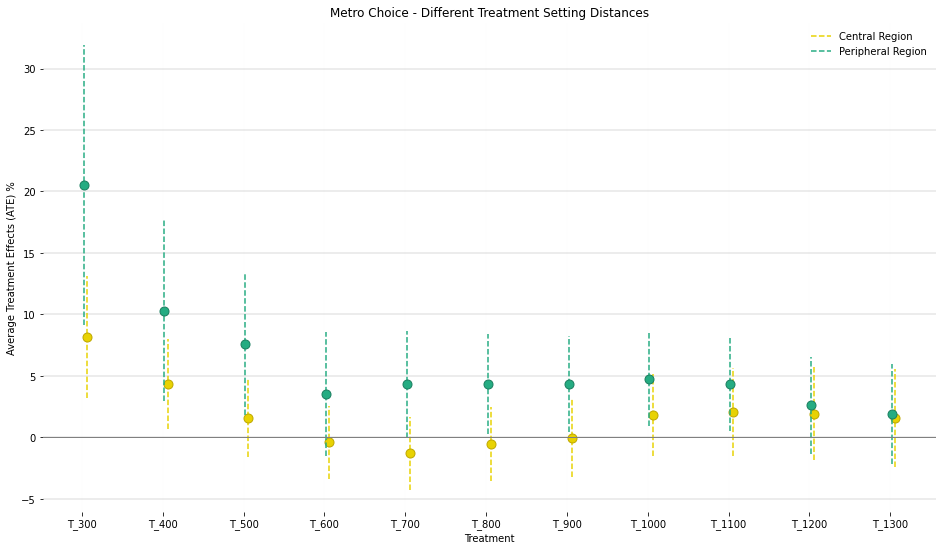

In [36]:
fig, ax = many_distance_plot(dataset_perif_aux, dataset_center_aux, list_t, modo="Taxa de Metrô", save=False)
plt.savefig("figs/diff-treat-distances_metro.png", dpi=300, bbox_inches='tight')
plt.show()

              LB        UB      coef       T  Centro
OD23:T -0.488495 -0.134927 -0.311711   T_300       0
OD23:T -0.244218 -0.015396 -0.129807   T_400       0
OD23:T -0.087111  0.092221  0.002555   T_500       0
OD23:T -0.039399  0.116105  0.038353   T_600       0
OD23:T -0.039529  0.096171  0.028321   T_700       0
OD23:T -0.009826  0.116313  0.053244   T_800       0
OD23:T  0.002239  0.123120  0.062680   T_900       0
OD23:T -0.034570  0.084376  0.024903  T_1000       0
OD23:T -0.074452  0.044606 -0.014923  T_1100       0
OD23:T -0.056701  0.065070  0.004185  T_1200       0
OD23:T -0.029505  0.096823  0.033659  T_1300       0
              LB        UB      coef       T  Centro
OD23:T -0.085670  0.059977 -0.012846   T_300       1
OD23:T -0.067138  0.041516 -0.012811   T_400       1
OD23:T -0.031562  0.061841  0.015139   T_500       1
OD23:T -0.006414  0.081283  0.037434   T_600       1
OD23:T  0.003090  0.090062  0.046576   T_700       1
OD23:T -0.040274  0.048789  0.004257   T_800  

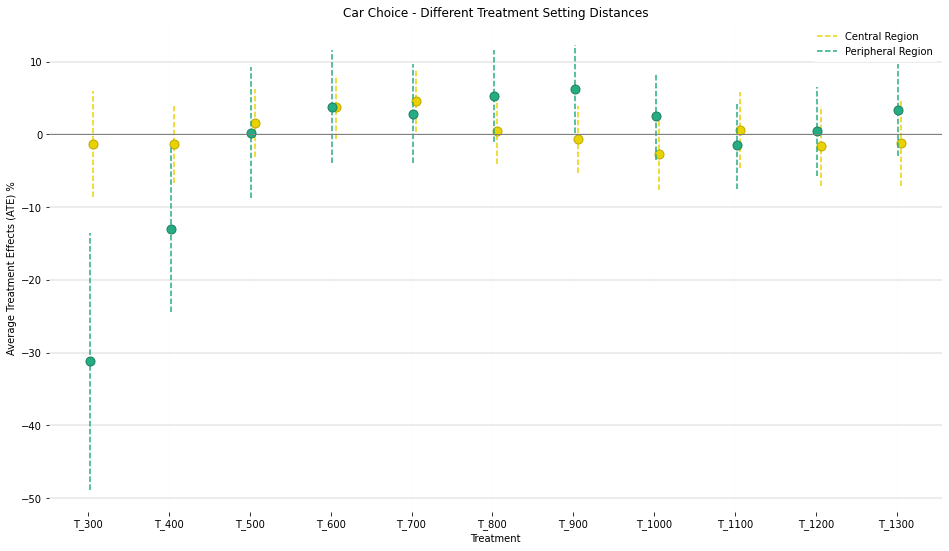

In [37]:
fig, ax = many_distance_plot(dataset_perif_aux, dataset_center_aux, list_t, modo="Taxa de Carro", save=False)
plt.savefig("figs/diff-treat-distances_car.png", dpi=300, bbox_inches='tight')
plt.show()

              LB        UB      coef       T  Centro
OD23:T  0.014549  0.344228  0.179389   T_300       0
OD23:T -0.059873  0.153311  0.046719   T_400       0
OD23:T -0.106694  0.060168 -0.023263   T_500       0
OD23:T -0.109618  0.035229 -0.037195   T_600       0
OD23:T -0.128822 -0.002512 -0.065667   T_700       0
OD23:T -0.098009  0.019472 -0.039269   T_800       0
OD23:T -0.129011 -0.016512 -0.072762   T_900       0
OD23:T -0.114684 -0.003936 -0.059310  T_1000       0
OD23:T -0.083919  0.026972 -0.028474  T_1100       0
OD23:T -0.102637  0.010748 -0.045945  T_1200       0
OD23:T -0.111890  0.005710 -0.053090  T_1300       0
              LB        UB      coef       T  Centro
OD23:T -0.069491  0.029833 -0.019829   T_300       1
OD23:T -0.068811  0.005287 -0.031762   T_400       1
OD23:T -0.057892  0.005730 -0.026081   T_500       1
OD23:T -0.043886  0.015848 -0.014019   T_600       1
OD23:T -0.050484  0.008699 -0.020892   T_700       1
OD23:T -0.024765  0.035774  0.005505   T_800  

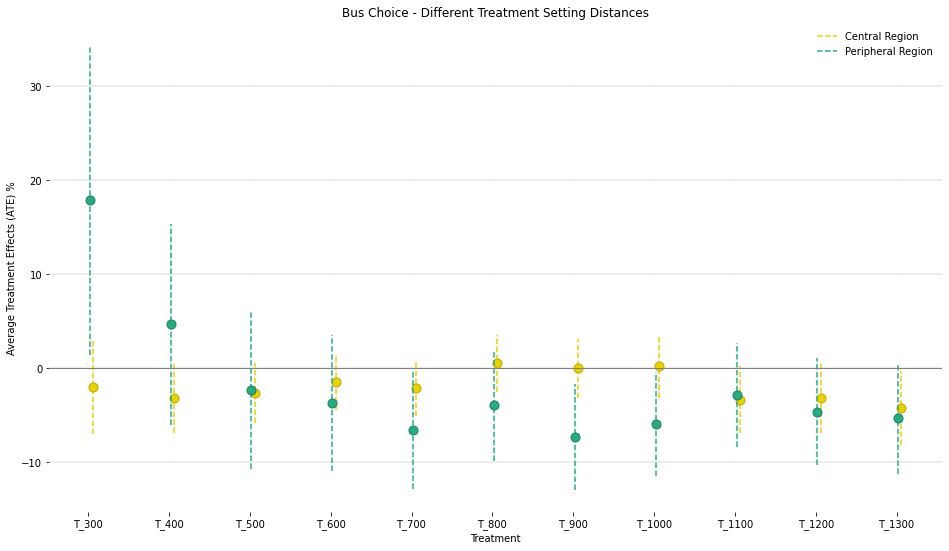

In [38]:
fig, ax = many_distance_plot(dataset_perif_aux, dataset_center_aux, list_t, modo="Taxa de Ônibus", save=False)
plt.savefig("figs/diff-treat-distances_bus.png", dpi=300, bbox_inches='tight')
plt.show()

### Random

In [41]:
print("--"*20 + "\nCentro")
did = random_t_did_test(dataset_center_aux, "T_500", COLS_MODELING, "Taxa de Metrô")
plot_final_table(did).to_excel("data/did_center_metro_t500_random.xlsx")
print("--"*20 + "\nPeriferia")
did = random_t_did_test(dataset_perif_aux, "T_500", COLS_MODELING, "Taxa de Metrô")
plot_final_table(did).to_excel("data/did_perif_metro_t500_random.xlsx")

----------------------------------------
Centro

-----------------
Original
-----------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     69.82
Date:                Tue, 24 Jun 2025   Prob (F-statistic):          6.80e-110
Time:                        23:05:33   Log-Likelihood:                -760.43
No. Observations:                5609   AIC:                             1539.
Df Residuals:                    5600   BIC:                             1599.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------